<a href="https://colab.research.google.com/github/andygoosh/OneTwoTrip-Contest/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import sklearn
if '0.22' != sklearn.__version__:
  !pip3 install scikit-plot
  !pip install -U scikit-learn
  import os
  os.kill(os.getpid(), 9)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import pandas as pd
import xarray
import requests
import datetime

import os
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
import xgboost as xgb
from pathlib import Path
import scikitplot as skplt
from google.colab import files, drive
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import tensorflow as tf
import tensorflow.keras as keras

print(tf.test.gpu_device_name())
print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)
assert ('0.22' == sklearn.__version__)

from keras import layers
from keras.callbacks import TensorBoard
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble

import warnings
warnings.filterwarnings('ignore')
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

GDRIVE_PATH = '/content/gdrive'
drive.mount(GDRIVE_PATH)
OTT_PATH = os.path.join(GDRIVE_PATH, 'My Drive/OTT', '')

Populating the interactive namespace from numpy and matplotlib
/device:GPU:0
2.1.0-rc1
2.2.4-tf
0.22
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
def anti_scaler(X):
  #Anti-StandardScaler для Field1 и Field14 тиснуто отсюда https://github.com/IlyaSviridov/OneTwoTrip-Contest/blob/master/EDA_fields_1.ipynb
  unique14 = np.unique(X['field14'])
  new_unique14 = np.round(unique14 / 0.14006639 - 0.27860731).astype(int)
  dict14 = {unique14[i]: new_unique14[i] for i in range(len(unique14))}
  X['field14'] = X['field14'].apply(lambda x: dict14[x])

  unique1 = np.unique(X['field1'])
  new_unique1 = np.round(unique1  / 0.077571 + 0.0765905).astype(int)
  dict1 = {unique1[i]: new_unique1[i] for i in range(len(unique1))}
  X['field1'] = X['field1'].apply(lambda x: dict1[x])
  return X

df_train = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv', index_col='orderid') #, dtype={'field1': np.float64, 'field14': np.float64})
df_test = pd.read_csv('https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_test.csv', index_col='orderid') #, dtype={'field1': np.float64, 'field14': np.float64})

df_train, df_oof = train_test_split(df_train, random_state=RS, shuffle=True, test_size=0.1)

df_train = anti_scaler(df_train)
df_test = anti_scaler(df_test)
df_oof = anti_scaler(df_oof)

TARGET = 'goal1'
FTS = list(filter(lambda x: 'field' in x, df_train.columns))

df_train.head()

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
126862,c2da187607dcd6243a1d32baa68168d70337bdadf5dabc...,0,4,8,8,1,1,0,1,1,0,0,9,3,3,-4,4,23,1,5,5,7,1,31,14,3,1,1,1,1,3,1,1,0,1,1,0,1,0,0,0,0
195018,d1516685f5bd283f8a9c11790eadc2e33d554379be2260...,0,-2,8,8,1,1,0,2,1,0,0,3,3,3,1,1,10,1,5,4,1,1,149,8,1,3,1,1,0,3,1,1,1,1,1,0,1,1,0,0,0
36083,40dca0bcacbb5dcd4898cd1d5354853981d64112285f2c...,0,-4,6,6,1,1,0,1,1,0,0,19,38,62,-4,2,1,1,7,1,1,1,1,12,2,1,2,1,0,2,1,1,0,0,0,0,0,0,0,0,0
114781,61adbd9a60a346a815fbbdd39603a295079c2a0ef60c72...,0,-4,10,10,1,1,0,1,1,0,1,15,8,3,-5,2,2,1,2,1,4,1,17,10,2,1,1,1,0,4,1,1,1,0,1,0,0,0,0,0,0
74627,8b43596cc465424e92446db00d83b4f3d9b871c73f38d7...,0,-7,8,9,1,1,0,1,1,1,0,13,21,3,-4,2,6,1,7,2,6,1,8,8,1,1,1,1,0,3,1,1,0,1,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


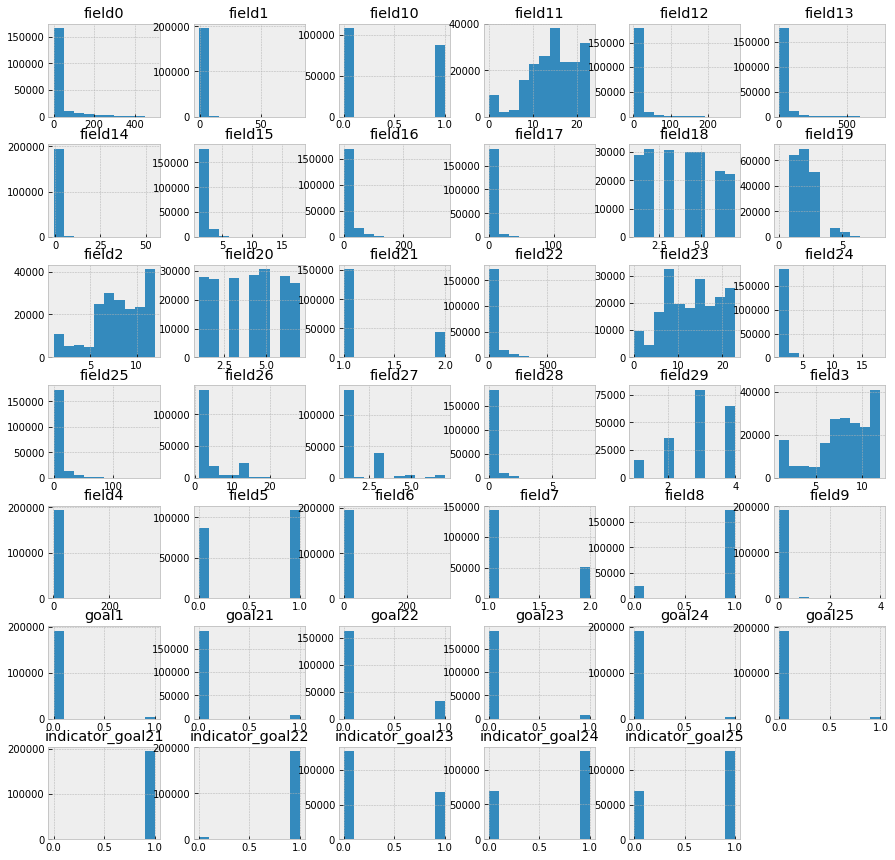

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
df_train.hist(ax=ax);

In [0]:
import seaborn as sns
sns.boxplot(x=X['14/4'])

In [0]:
df_train['field6'].quantile(0.99)

21.0

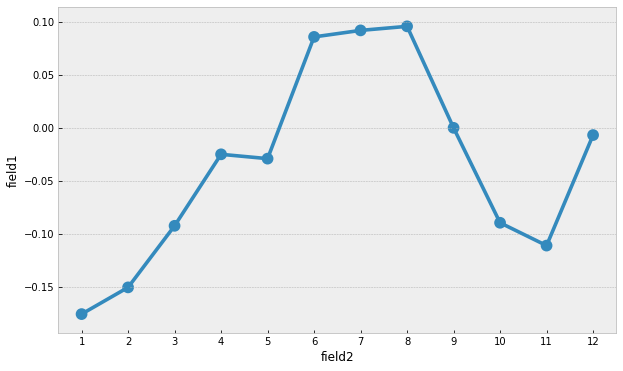

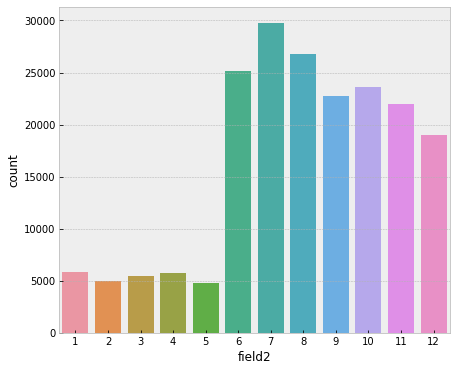

In [0]:
X = df_train

df11 = X.groupby(['field2'])[['field1']].mean()
df11.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.pointplot(x='field2', y='field1', data=df11, ax=ax);

fig, ax = plt.subplots(figsize=(7, 6))
sns.countplot(X['field2'], ax=ax);
#sns.scatterplot(x='field11', y='field1', data=X, alpha=0.8, ax=ax);

In [0]:
df_train.describe()
df_test.describe()
full = pd.concat([df_train, df_test])
full.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,field0,field1,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field2,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,field3,field4,field5,field6,field7,field8,field9,goal1,goal21,goal22,goal23,goal24,goal25,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25
count,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000,176450.000000,176450.000000,176450.000000,176450.000000,176450.000000,176450.000000,631461.000000,631461.000000,631461.000000,631461.000000,631461.000000
mean,28.398766,0.000035,0.447822,14.615419,11.986484,27.315188,-0.000038,1.518257,15.628192,2.993146,3.809008,2.076066,7.976830,3.989201,1.226880,39.014093,13.045350,1.407138,4.876002,3.900615,1.751917,0.087421,2.979620,7.867233,3.754564,0.556582,1.576412,1.263595,0.879943,0.023697,0.022137,0.036656,0.168507,0.038663,0.022465,0.015211,0.994991,0.979750,0.348294,0.645028,0.647807
std,69.651831,0.999939,0.497270,5.526270,19.692027,58.235302,1.001244,0.966615,25.436927,8.515411,1.932821,0.977935,2.754806,1.976955,0.418815,74.104875,6.131847,0.799156,11.624236,4.255248,1.379383,0.368993,0.919524,3.010160,18.231438,0.496789,5.574152,0.440583,0.325028,0.163902,0.147128,0.187917,0.374317,0.192790,0.148192,0.122392,0.070597,0.140854,0.476430,0.478505,0.477654
min,0.000000,-0.859222,0.000000,0.000000,1.000000,0.000000,-0.941441,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.471365,0.000000,11.000000,4.000000,3.000000,-0.521242,1.000000,2.000000,1.000000,2.000000,1.000000,6.000000,2.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,-0.238651,0.000000,15.000000,5.000000,4.000000,-0.241109,1.000000,6.000000,1.000000,4.000000,2.000000,8.000000,4.000000,1.000000,17.000000,13.000000,1.000000,1.000000,2.000000,1.000000,0.000000,3.000000,8.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,13.000000,0.149205,1.000000,19.000000,11.000000,26.000000,0.179090,2.000000,18.000000,1.000000,5.000000,3.000000,10.000000,6.000000,1.000000,42.000000,18.000000,2.000000,1.000000,5.000000,3.000000,0.000000,4.000000,10.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,507.000000,82.142134,1.000000,23.000000,316.000000,928.000000,55.225183,18.000000,340.000000,179.000000,7.000000,9.000000,12.000000,7.000000,2.000000,1049.000000,23.000000,18.000000,193.000000,30.000000,7.000000,16.000000,4.000000,12.000000,756.000000,1.000000,344.000000,2.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
data_mean, data_std = df_train.field9.mean(), df_train.field9.std()
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in df_train.field9 if x < lower or x > upper]
len(outliers), len(df_train.field4)

(4350, 196056)

In [0]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a.field0.max()


363

In [0]:
def vectorize( X, cols ):

  for col in cols:
    df = pd.get_dummies(X[col])
    df.columns = ['%s_%d' % (col, i) for i in range(df.shape[1])]
    X = X.join(df)
  X.drop(cols, axis=1, inplace=True)

  return X

def undersample_data(X):
    # Separate majority and minority classes
    df_majority = X[X['goal1']==0]
    df_minority = X[X['goal1']==1]
    
    n_samples = math.floor( X['goal1'].sum() * undersample )

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=n_samples,     # to match minority class
                                    random_state=RS) # reproducible results
    
    # Combine minority class with downsampled majority class
    X = pd.concat([df_majority_downsampled, df_minority])# Separate majority and minority classes
    
    return X

field0 - количество дней прошедших с предыдущей покупки

field1 - общая цена всех билетов.

field2 - месяц покупки билетов

field3 - месяц вылета

field4 номер покупки, соответсвует месяцу покупки билета field2

field5 - мб это индикатор регистрации

field9 - количество билетов детей (до одного год)

field11 - час вылета

field15 - количество всех билетов, = field24 + field28 + field9

field16 - количество дней с момента покупки до момента вылета

field18 - день недели покупки

field21 - это год покупки. В этом признаке значения идут в обратном порядке. 2 - первый год, 1 - второй год

field23 - час покупки билетов

field24 - количество билетов взрослых людей

field28 - количество билетов детей (от 2 до 4 лет)

field20 - день недели вылета

In [0]:
def remove_outliers( X, y ):
  # remove the outlier rows
  X = X[X.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
  # remove the columns with equal values
  X = X.loc[:,X.apply(pd.Series.nunique) != 1]
  # fix the target index
  y = y[y.index.isin(X.index)]
  return X, y

def mark_outliers( X, outlier_ratio=0 ):
  outlier_index = X.apply(lambda x: np.abs(x - x.mean()) / x.std() < outlier_ratio).all(axis=1)
  X['otl'] = 1
  X.loc[outlier_index, 'otl'] = 0
  return X

def add_linear(X, cols=[], sets=2):
  for i in cols if len(cols) > 0 else X.columns:
    for j in X.columns:
      if i != j: 
        X[f'{i}*{j}'] = X[i]*X[j]
        X[f'{i}+{j}'] = X[i]+X[j]
  return X

In [0]:
a = ['field0']
np.unique(a)

array(['field0'], dtype='<U6')

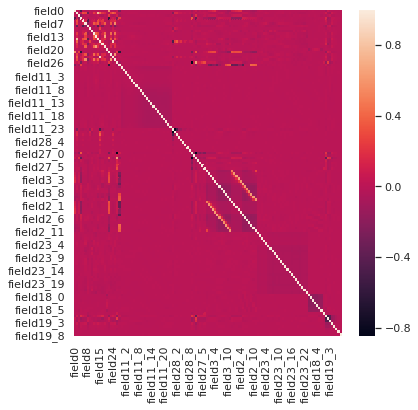

In [0]:
import seaborn as sns; sns.set()
#X, y = prepare_data(df_train)
ax = sns.heatmap(X.corr())

In [0]:
X.corr().nlargest(10)

In [0]:
corr = df_train.corr()
corr.field2['field29'], corr.field15['field24']

(0.9539990460663368, 0.8997383624774794)

In [0]:
def add_polynomial_inner( X, poly ):
  X = X
  X = pd.DataFrame(poly.transform(X), index=X.index, columns = poly.get_feature_names(X.columns))
  return X
    
def add_polynomial(X_train, X_cv=None, degree=2):
  poly = sklearn.preprocessing.PolynomialFeatures(degree)
  poly.fit(X)
  
  X_train = add_polynomial_inner(X_train, poly)
  if X_cv is not None:
      X_cv = add_polynomial_inner(X_cv, poly)

  #poly_corrs = poly_features.corrwith(y).sort_values(ascending=False)
  #poly_corrs = poly_features.corrwith(y).nlargest(20)

  return X_train, X_cv, poly

def add_neighbors_inner( X, neigh ):
  X = X.copy()
  dists, _ = neigh.kneighbors(X, return_distance=True)
  X['K-mean'] = dists.mean(axis=1).reshape(-1, 1)
  X['K-max'] = dists.max(axis=1).reshape(-1, 1)
  return X

def add_neighbors(X_train, X_cv=None, n_neighbors=5):
  neigh = skl.neighbors.NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
  neigh.fit(X_train)

  X_train = add_neighbors_inner(X_train, neigh)
  if X_cv is not None:
      X_cv = add_neighbors_inner(X_cv, neigh)

  return X_train, X_cv, neigh

In [0]:
def estimate(X, y, model, plot=True):
  X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)
  
  '''
  # apply class weights
  class_weights = list(skl.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.values.ravel()))
  w_array = pd.Series(np.ones(y_train.shape[0], dtype = 'float32'), index=y_train.index)\
                    .apply(lambda x: class_weights[0] if x==0 else class_weights[1])
  '''
  #try:
  #  sklearn.utils.validation.check_is_fitted(model, type(model).__name__, 'Model is not fitted')
  #except sklearn.utils.validation.NotFittedError:
  boosters = ['XGBClassifier', 'LGBMClassifier']
  if type(model).__name__ in boosters:
    print(0, end='')
    model.fit(X_train, y_train, 
              eval_set=[(X_cv, y_cv)],
              early_stopping_rounds=200,
              verbose=False,
              #sample_weight=w_array
              )
  else:
    print(1, end='')
    model.fit(X_train, y_train.values.ravel(), 
              #sample_weight=w_array
              )

  if plot == True:
    plot_cm_and_roc(model, X_train, y_train, 'train')
    plot_cm_and_roc(model, X_cv, y_cv, 'cv')

  return model

In [0]:
def fit_estimate( X, y, model_generator, n_folds = 5, n_neighbors=0, degree=0, plot=False):

  scores = []
  models = []
  neighbs = []
  polies = []

  folds = list(skl.model_selection.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X, y))
  for j, (train_idx, val_idx) in enumerate(folds):

    X_train, X_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_cv = y[train_idx], y[val_idx]

    if degree > 1:
      X_train, X_cv, poly = add_polynomial(X_train, X_cv, degree)
      polies.append(poly)
    
    if n_neighbors > 0:
      X_train, X_cv, neigh = add_neighbors(X_train, X_cv, n_neighbors)
      neighbs.append(neigh)

    model = model_generator()

    #try:
    #  sklearn.utils.validation.check_is_fitted(model, type(model).__name__, 'Model is not fitted')
    #except sklearn.utils.validation.NotFittedError:
    boosters = ['XGBClassifier', 'LGBMClassifier']
    if type(model).__name__ in boosters:
      model.fit(X_train, y_train, 
                eval_set=[(X_cv, y_cv)],
                early_stopping_rounds=200,
                verbose=False,
                #sample_weight=w_array
                )
    else:
      print(1, end='')
      model.fit(X_train, y_train.values.ravel(), 
                #sample_weight=w_array
                )

    if plot == True:  
      plot_cm_and_roc(model, X_cv, y_cv, 'cv')

    y_pred_cv = model.predict_proba(X_cv)
    # score = skl.metrics.roc_auc_score(keras.utils.to_categorical(y_cv), y_pred_cv) # works for multiclass
    score = skl.metrics.roc_auc_score(y_cv, y_pred_cv[:, 1]) # better one for binary
    scores.append(score)
    models.append(model)

  # estimate OOF
  model = models[np.argmax(scores)]

  X_oof, y_off = prepare_data(df_oof)
  if n_neighbors > 0:
    neigh = neighbs[np.argmax(scores)]
    X_oof = add_neighbors_inner(X_oof, neigh)

  plot_cm_and_roc(model, X_oof, y_off, 'oof')
  pred = model.predict_proba(X_oof)
  oof = skl.metrics.roc_auc_score(y_off, pred[:, 1])
  del X_oof
  
  print(f'# {type(model).__name__} RS:{RS} \
          {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} \
          OOF: {oof:.5f}')
  
  return scores, models, neighbs, polies

In [0]:
  pred_proba = model.predict_proba(X, ntree_limit=model.best_ntree_limit)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  plt.suptitle(f'{type(model).__name__} {title}')
  skplt.metrics.plot_confusion_matrix(y, pred_proba.argmax(axis=1), ax=ax1)
  skplt.metrics.plot_roc(y, pred_proba, ax=ax2)
  
  plt.show()

In [0]:
def plot_permutation_importance(model, X_test, y_test, X_cv=None, y_cv=None):
  result = permutation_importance(model, X_test, y_test.values.ravel(), n_repeats=10, random_state=RS)
  sorted_idx = result.importances_mean.argsort()

  if  X_cv is None:
    fig, ax = plt.subplots(figsize=(15,5))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    ax1.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax1.set_title("Test Permutation Importance of each feature")
    ax1.set_ylabel("Features")

    result = permutation_importance(model, X_cv, y_cv.values.ravel(), n_repeats=10, random_state=RS)
    sorted_idx = result.importances_mean.argsort()

    ax2.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax2.set_title("CV Permutation Importance of each feature")
    ax2.set_ylabel("Features")

    fig.tight_layout()

  plt.show()

def plot_cm_and_roc(model, X, y, title=''):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  fig.suptitle(f'{type(model).__name__} {title}')
  skl.metrics.plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues, ax=ax1)
  skl.metrics.plot_roc_curve(model, X, y, ax=ax2)
  '''
  pred_proba = model.predict_proba(X, ntree_limit=model.best_ntree_limit)
  fig = plt.figure(figsize=(15,4))
  fig.suptitle(f'{type(model).__name__} title')

  ax1 = fig.add_subplot(1, 2, 1)
  skplt.metrics.plot_confusion_matrix(y, pred_proba.argmax(axis=1), ax=ax1)
  ax2 = fig.add_subplot(1, 2, 2)
  skplt.metrics.plot_roc(y, pred_proba, ax=ax2)
  '''
def oof_estimate_plot(model):
  X_oof, y_off = prepare_data(df_oof)
  plot_cm_and_roc(model, X_oof, y_off, 'oof')

  if hasattr(model, 'best_ntree_limit'): pred = model.predict_proba(X_oof, ntree_limit=model.best_ntree_limit) 
  else: pred = model.predict_proba(X_oof)

  oof = skl.metrics.roc_auc_score(y_off, pred[:, 1])
  del X_oof
  return oof

def plot_cv_scores(scores, label='', ax=None):
  # plot CV scores
  if ax is None:
    plt.figure()
    plt.xlabel('Number of folds')
    plt.ylabel('Cross validation score')
    plt.plot(range(1, len(scores) + 1), scores, label=label)
    plt.legend()
    plt.show()
  else:
    ax.plot(range(1, len(scores) + 1), scores, label=label)
    ax.legend()

def plot_history(history, metric_names):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.subplots(figsize=(18,6))

  num_plots = len(metric_names)

  for i in range(num_plots):
    plt.subplot(1,num_plots,i+1)
    plt.xlabel('Epoch')
    plt.ylabel(metric_names[i])
    plt.plot(hist['epoch'], hist[metric_names[i]],
            label='Train %s' % metric_names[i])
    plt.plot(hist['epoch'], hist['val_%s' % metric_names[i]],
            label = 'Val %s' % metric_names[i])
    plt.legend()
  
  plt.show()

In [47]:
def add_aggregates(X, aggs=[], cols=[]):

  if len(aggs) == 0:
    aggs = ['std', 'sum', 'max', 'min', 'mean', 'count']

  if len(cols) == 0:
    cols = list(filter(lambda x: 'field' in x, X.columns))

  # add aggregates for userid
  grouped_by = X.groupby('userid')
  all_features = []
  
  # add count
  if 'count' in aggs:
    grouped = grouped_by.agg({'userid': 'count'})
    grouped.columns = ['count']
    all_features.append( grouped )
    aggs.remove('count')
  
  for col in cols:
    grouped = grouped_by.agg({col: aggs}) 
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    all_features.append(grouped)

  if len(all_features)>0:
    all_features = pd.concat(all_features, axis=1)
    X = X.merge(all_features, on=('userid'))

  X.fillna(0, inplace=True)

  return X.drop(['userid'], axis=1)

def check_aggregates_result():
  a = df_train.groupby('userid', as_index=False).count()
  a = a[a.field0 == 5]
  a = df_train.loc[df_train.userid.isin([*a.userid])]
  #print(a.iloc[1].userid)
  a = a[a.userid == a.iloc[0].userid]

  return add_aggregates(a, cols=['field0'])
  
check_aggregates_result()

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,count,field0_std,field0_sum,field0_max,field0_min,field0_mean
0,0,-8,8,9,1,1,0,1,1,0,0,15,1,3,-5,1,11,1,3,3,7,1,17,20,1,1,7,5,0,3,1,1,0,1,1,0,0,0,0,0,0,5,33.261088,143,71,0,28.600000
1,71,-8,1,1,4,0,0,1,1,0,0,20,12,5,-5,1,9,1,6,3,1,2,1,7,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,5,33.261088,143,71,0,28.600000
2,57,-9,11,12,3,0,0,1,1,0,0,14,1,3,-6,1,28,1,5,3,5,1,17,19,1,1,7,5,0,4,1,1,0,1,1,0,0,0,0,0,0,5,33.261088,143,71,0,28.600000
3,0,-9,1,1,5,0,0,1,1,0,1,20,4,3,-6,1,11,1,6,3,3,2,17,9,1,1,5,3,0,1,1,1,0,1,1,0,0,0,0,0,0,5,33.261088,143,71,0,28.600000
4,15,-9,9,10,2,0,0,1,1,0,0,16,12,3,-6,1,29,1,4,3,5,1,17,21,1,1,1,1,0,3,1,1,0,1,1,0,0,0,0,0,0,5,33.261088,143,71,0,28.600000


In [0]:
def to_buckets(X, bins):
  return pd.cut(X, 10, labels=False)


In [0]:
print(skl.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.values.ravel()))
counts = np.unique(y, return_counts=True)[1]
print(counts[0]/counts[1])

In [0]:
def get_best_params_xgbc():
  estimators = 298
  return {'base_score': 0.9883241431311958, 
  'booster': 'gbtree',
  'colsample_bylevel': 0.8954745282201794, 
  'colsample_bynode': 0.9053728787963939, 
  'colsample_bytree': 0.37737648074076036, 
  'gamma': 51, 
  'learning_rate': 0.06869149756603576, 
  'max_delta_step': 22, 
  'max_depth': 4, 
  'min_child_weight': 0.8940873051252118, 
  'missing': None,
  'n_estimators': estimators, 
  'nthread': None,
  'objective': 'binary:logistic',
  'random_state': RS,
  'reg_alpha': 0.2901487558842103, 
  'reg_lambda': 0.7240220329478356, 
  'scale_pos_weight': 0.11997115325466545,  #0.04082
  'seed': None,
  'silent': None,
  'subsample': 0.699092108437742,
  'verbosity': 0,
  # If there’s more than one metric in the eval_metric parameter given in params, the last metric will be used for early stopping
  'eval_metric': ['logloss', 'auc'],
  # 'rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-'
  'tree_method': 'gpu_hist',
  'updater': 'grow_gpu_hist',
  'predictor': 'gpu_predictor'
  }

def get_best_params_lgbm():
  estimators = 203
  return {'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 0.3811304824216669,
    'importance_type': 'split',
    'learning_rate': 0.016659893432998896,
    'max_depth': 20,
    'metric': ['logloss', 'auc'],
    'min_child_samples': 12,
    'min_child_weight': 0.0036350360157623163,
    'min_split_gain': 0.9619961904304549,
    'n_estimators': estimators,
    'n_jobs': -1,
    'num_leaves': 32,
    'objective': 'binary',
    'random_state': RS,
    'reg_alpha': 0.8022751137716411,
    'reg_lambda': 0.8186913351852023,
    'silent': True,
    'subsample': 0.5967826661188248,
    'subsample_for_bin': 200000,
    'subsample_freq': 14
    }


In [0]:
def check_agregates_score():
  AGGREGATES = ['count', 'std', 'sum', 'min', 'max', 'mean']

  FTS = list(filter(lambda x: 'field' in x, df_train.columns))
  scores = []
  attrs = []

  X_, y = prepare_data(df_train)
  model = estimate(X_, y, XGBClassifier(**get_best_params_xgbc()), plot=False)
  if hasattr(model, 'best_ntree_limit'): scores.append(model.best_score)
  if hasattr(model, 'best_score_'): scores.append(model.best_score_['valid_0']['auc'])
  attrs.append(('baseline', ))

  grouped_by = df_train.groupby('userid')
  for col in tqdm(FTS):
    for agg in AGGREGATES:
      X_ = add_aggregates(df_train, aggs=[agg], cols=[col])
      X_, y = prepare_data(X_)
      #model = estimate(X_, y, LGBMClassifier(**get_best_params_lgbm()), plot=False)
      model = estimate(X_, y, XGBClassifier(**get_best_params_xgbc()), plot=False)
      if hasattr(model, 'best_ntree_limit'): scores.append(model.best_score)
      if hasattr(model, 'best_score_'): scores.append(model.best_score_['valid_0']['auc'])
      attrs.append((agg, col))

  arr = np.array(scores)
  for i in arr.argsort()[-10:][::-1]:
    print(scores[i], attrs[i])

check_agregates_score()

0

000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0.690052 ('baseline',)
0.682247 ('mean', 'field10')
0.682247 ('min', 'field10')
0.682247 ('sum', 'field10')
0.682247 ('std', 'field10')
0.682247 ('count', 'field10')
0.682247 ('mean', 'field9')
0.682247 ('max', 'field9')
0.682247 ('min', 'field9')
0.682247 ('sum', 'field9')


## Importance

In [87]:
importance = model.get_booster().get_score(importance_type='weight')
imp_sorted = sorted(importance.items(), key = lambda kv: (kv[1], kv[0]), reverse=True)
imp_filtered = list(filter(lambda kv: kv[1] > 100, imp_sorted))
print([x[0] for x in imp_filtered])

['field12', 'field16', 'field1', 'field14', 'field13', 'field22', 'field6', 'field23', 'field0', 'field25', 'field11']


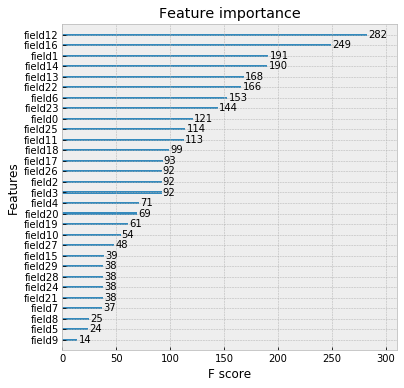

In [52]:
xgb.plot_importance(model)
#xgb.plot_tree(model, num_trees=10)

In [0]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
print(feat_importances.nlargest(30).index)

In [0]:
X, y = prepare_data( df_train)

from sklearn.utils import all_estimators

def_params = {
    'random_state': RS,
    'n_jobs': -1
}

estimators = all_estimators(type_filter='classifier')
for name, class_ in estimators:
  print(class_)
  #try:
  #  model = estimate(X, y, class_());
  #except:
  #  pass

In [0]:
def prepare_data( data ):
  X = data[FTS]
  y = []

  if TARGET in data.columns: y = data[TARGET].values.ravel()
  #X = X.drop(['field5', 'field20'], axis=1)
  #cols = ['field10', 'field14'] # lb 0.673564
  #cols = ['field5', 'field20', 'field18', 'field27', 'field29', 'field10', 'field13']
  #cols = ['field5', 'field18', 'field20', 'field27', 'field29'] # lb 0.675374
  #cols = ['field20', 'field23']
  #cols = ['field5', 'field20'] # lb 0.674808
  #cols = ['field5'] # lb 0.675084
  #cols = ['field4', 'field5', 'field9', 'field10', 'field13', 'field15', 'field17', 'field22', 'field23', 'field24', 'field26'] # 0.673498

  X = add_linear(X, ['field12', 'field16', 'field1', 'field14', 'field13', 'field22', 'field6', 'field23', 'field0', 'field25', 'field11'])
  cols = []
  #X = add_aggregates(data, aggs=['mean'], cols=['field0'])

  return X.drop(cols, axis=1), y

In [0]:
X[X['field0_mean']!=0]

,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal21,goal22,goal23,goal24,goal25,goal1,field0_mean
5,5,-2,10,10,2,0,0,1,1,0,0,17,3,3,-3,2,1,1,3,2,4,1,100,13,2,1,3,1,0,4,1,1,0,0,0,0,0,0,0,0,0,2.500000
6,0,0,10,10,1,1,0,1,1,0,0,21,8,156,-2,2,5,1,5,1,3,1,1,6,2,1,3,1,0,4,1,1,1,1,1,0,1,0,0,0,0,2.500000
7,87,-1,4,4,4,0,0,1,1,0,1,13,9,3,2,1,1,1,5,3,6,2,3,13,1,1,5,3,0,2,1,1,1,0,0,0,0,1,0,0,0,31.666667
8,8,-5,1,1,2,0,0,1,1,0,1,11,4,3,-3,1,0,1,1,3,1,2,17,22,1,1,5,3,0,1,1,1,0,0,0,0,0,0,0,0,0,31.666667
9,0,0,12,12,1,1,2,1,1,0,1,12,8,3,0,2,1,1,7,3,1,1,36,10,2,1,5,3,0,4,1,1,1,1,1,0,1,0,0,0,0,31.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176159,150,-7,12,1,2,0,1,1,1,0,1,22,4,4,-4,1,30,1,1,4,3,1,103,22,1,1,1,1,0,4,1,1,0,1,1,0,0,0,0,0,0,150.000000
176208,33,-6,10,10,2,0,0,1,1,0,0,13,5,5,-3,1,0,1,3,1,3,1,1,20,1,1,3,1,0,4,1,1,0,0,0,0,0,0,0,0,0,33.000000
176217,34,-7,10,10,2,0,0,2,1,0,0,16,5,3,-4,1,3,1,6,2,2,1,46,15,1,18,2,1,0,4,1,1,0,1,1,0,0,0,0,0,0,34.000000
176284,218,0,7,7,2,0,16,1,0,0,1,21,5,3,2,1,4,1,1,1,5,2,5,8,1,1,1,1,0,3,1,1,0,1,1,0,1,0,0,0,0,218.000000


## Recursive Feature Elimination

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.


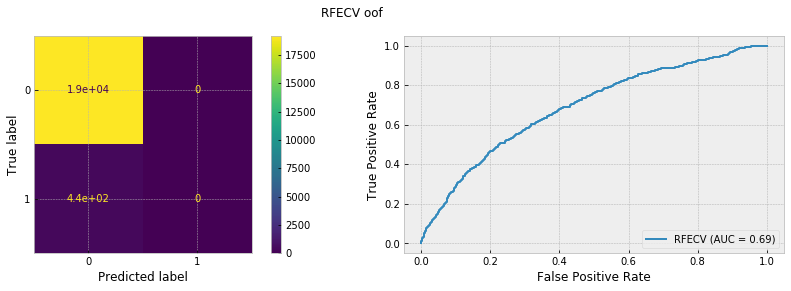

# LGBMClassifier RS:77 10x CV: 0.68728 ± 0.00101           OOF: 0.68929 ~['field5', 'field7', 'field8', 'field9']
Optimal number of features :26


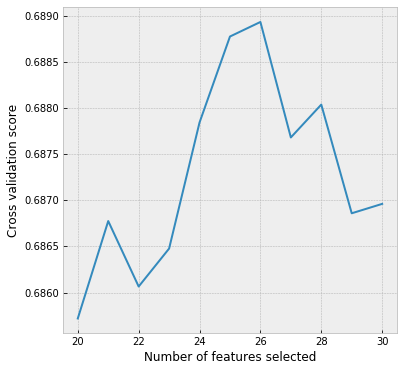

CPU times: user 37.4 s, sys: 423 ms, total: 37.8 s
Wall time: 8min 10s


In [0]:
%%time
from sklearn.feature_selection import RFECV
# XGBClassifier CV: 0.6784501167635486 ± 0.01855717343073274 OOF: 0.6849985940210219 ~['field5', 'field20'] Baseline
# XGBClassifier CV: 0.6862505904663256 ± 0.0010323194363471226 OOF: 0.7056287931991523 10f, all fts 0.675026 lb

# XGBClassifier RS:77           5x CV: 0.68740 ± 0.00071           OOF: 0.68938           ~[]
# XGBClassifier RS:77 10x CV: 0.68861 ± 0.00071           OOF: 0.68378 ~['field5']


X, y = prepare_data( df_train )
n_folds = 10
rfe = RFECV(XGBClassifier(**get_best_params_xgbc()),
#rfe = RFECV(LGBMClassifier(**get_best_params_lgbm()),
            cv=StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS), 
            scoring='roc_auc', verbose=1, min_features_to_select=20, step=1, n_jobs=-1)
rfe.fit(X, y)

model = rfe

print(f'# {type(rfe.estimator_).__name__} RS:{RS} {n_folds}x CV: {np.mean(rfe.grid_scores_):.5f} ± {np.std(rfe.grid_scores_):.5f} \
          OOF: {oof_estimate_plot(rfe):.5f} ~{X.iloc[:, ~rfe.support_].columns.tolist()}')

print(f'Optimal number of features :{rfe.n_features_}')
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(rfe.min_features_to_select, len(rfe.grid_scores_) + rfe.min_features_to_select), rfe.grid_scores_)
plt.show()

In [0]:
# estimate OOF
oof = oof_estimate_plot(model)

In [0]:
cols = X.iloc[:, rfe.support_].columns.tolist()
cols = [x for _,x in sorted(zip(rfe.ranking_,cols))]
print(f'Keep: {cols}')

Keep: ['field0', 'field1', 'field11', 'field12', 'field13', 'field14', 'field15', 'field16', 'field17', 'field18', 'field19', 'field2', 'field21', 'field22', 'field23', 'field25', 'field26', 'field28', 'field3', 'field7', 'field9', 'field6', 'field27', 'field10']


In [0]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

## ExhaustiveFeatureSelector

In [0]:
%%time
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# EFS 28: Remove: ['field10', 'field14'], 0.6889053714968825, 5f
# XGBClassifier RS:77 3x CV: 0.68726 (29-30) ~['field3']
# XGBClassifier RS:77 3x CV: 0.68811 (28-30) ~['field0', 'field13']

X, y = prepare_data( df_train ) 
n_folds = 3
efs1 = EFS(XGBClassifier(**get_best_params_xgbc()), 
           min_features=28,
           max_features=30,
           scoring='roc_auc',
           print_progress=True,
           cv=list(StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X,y)),
           n_jobs=-1
           )
efs1 = efs1.fit(X, y)

print(f'# {type(model).__name__} RS:{RS} {n_folds}x CV: {efs1.best_score_:.5f} \
        ({efs1.min_features}-{efs1.max_features}) ~{[x for x in FTS if x not in efs1.best_feature_names_]}')

Features: 466/466

# XGBClassifier RS:77 3x CV: 0.68811         ~['field0', 'field13']
CPU times: user 9.74 s, sys: 1.7 s, total: 11.4 s
Wall time: 37min 44s


## SequentialFeatureSelector

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  3.2min finished

[2019-12-18 13:44:48] Features: 1/35 -- score: 0.6322793991159648[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  3.1min finished

[2019-12-18 13:47:55] Features: 2/35 -- score: 0.6628190940125211[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:  3.5min finished

[2019-12-18 13:51:24] Features: 3/35 -- score: 0.6683265355095487[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  85 out o

<Figure size 864x648 with 0 Axes>

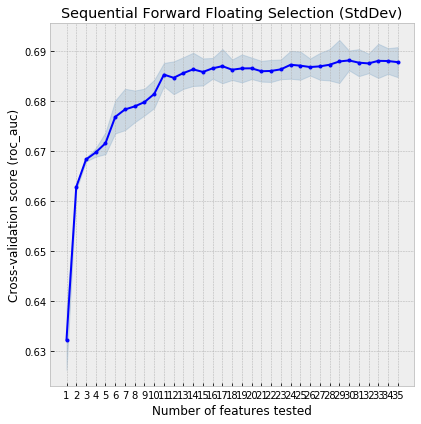

0.6881440619914809
Remove: ['field1', 'field2', 'field3', 'field4', 'field5', 'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field13', 'field15', 'field16', 'field17', 'field19', 'field20', 'field23', 'field24', 'field26', 'field29']
CPU times: user 38.6 s, sys: 7.34 s, total: 45.9 s
Wall time: 1h 53min 25s


In [0]:
%%time
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

X, y = prepare_data( df_train ) 
n_folds=2
sfs1 = SFS(XGBClassifier(**get_best_params_xgbc()), 
           k_features=(17, 35), 
           forward=True,
           floating=False, 
           verbose=2,
           scoring='roc_auc', 
           cv=list(StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS).split(X,y)),
           n_jobs=-1,
           )
sfs1 = sfs1.fit(X, y)

plt.figure(figsize=(12, 9))
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev', marker='.', ylabel='Cross-validation score (roc_auc)')
plt.title('Sequential Forward Floating Selection (StdDev)')
plt.xlabel('Number of features tested')
plt.ylabel('Cross-validation score (roc_auc)')
plt.tight_layout()
#plt.show()
plt.show(block=False)

print(sfs1.k_score_)
print(f'Remove: {[x for x in FTS if x not in sfs1.k_feature_names_]}')

fname = os.path.join(OTT_PATH, 'SFS_set_linear_30fts_5f.txt')
with open(fname, 'w') as text_file:
  print(f'sfs1.k_score_: {sfs1.k_score_}', file=text_file)
  print(f'sfs1.k_feature_names_: {sfs1.k_feature_names_}', file=text_file)
  print(f'Remove: {[x for x in FTS if x not in sfs1.k_feature_names_]}', file=text_file)
  print(f'sfs1.subsets_: {sfs1.subsets_}', file=text_file)

#files.download(text_file.name)

## SelectKBest

VarianceThreshold RS:7 10x CV: 0.68995 ± 0.01383 ~['field9']
SelectKBest RS:7 10x CV: 0.68876 ± 0.01364 ~[]
SelectFpr RS:7 10x CV: 0.68637 ± 0.01300 ~['field3', 'field4', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
SelectFdr RS:7 10x CV: 0.68430 ± 0.01154 ~['field3', 'field4', 'field9', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
SelectFwe RS:7 10x CV: 0.68404 ± 0.01065 ~['field2', 'field3', 'field4', 'field9', 'field11', 'field18', 'field19', 'field20', 'field23', 'field26', 'field27', 'field28', 'field29']


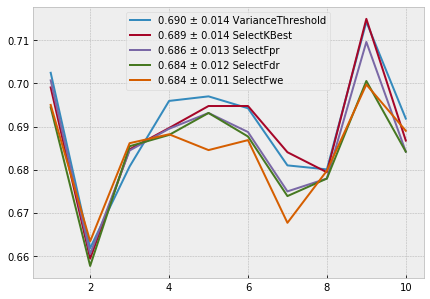

In [0]:
from sklearn.feature_selection import SelectKBest, SelectFpr, SelectFdr, SelectFwe

X, y = prepare_data( df_train )
n_folds=10

models = []
models.append(sklearn.feature_selection.VarianceThreshold(threshold=(.9 * (1 - .9))).fit(X, y))
models.append(SelectKBest(score_func=sklearn.feature_selection.f_classif, k=X.shape[1]).fit(X, y))
models.append(SelectFpr(score_func=sklearn.feature_selection.f_classif).fit(X, y))
models.append(SelectFdr(score_func=sklearn.feature_selection.f_classif).fit(X, y))
models.append(SelectFwe(score_func=sklearn.feature_selection.f_classif).fit(X, y))

fig, ax = plt.subplots(figsize=(7,5))
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
for m in models:
  pipe = make_pipeline(m, XGBClassifier(**get_best_params_xgbc()))
  scores = cross_val_score(pipe, X, y, scoring='roc_auc', verbose=0, n_jobs=-1, cv=skf)
  #oof = oof_estimate_plot(pipe)
  print(f'{type(m).__name__} RS:{RS} {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} ~{[x for x in FTS if x not in X.columns[m.get_support(indices=True)]]}')
  label = f'{np.mean(scores):.3f} ± {np.std(scores):.3f} {type(m).__name__}'
  plot_cv_scores(scores, label, ax)

## 5 KFold estimation

In [0]:
%%time
# XGBClassifier RS:77 10x CV: 0.68632 ± 0.01004 OOF: 0.70910 ~[]
# XGBClassifier RS:77 10x CV: 0.68756 ± 0.01044 OOF: 0.70477 ~['field5', 'field18', 'field20', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68658 ± 0.00903 OOF: 0.70523 ~['field10', 'field14']
# XGBClassifier RS:77 10x CV: 0.68625 ± 0.00975 OOF: 0.70811 ~['field5', 'field20'] 0.67496 lb 0.674808

# XGBClassifier RS:77 10x CV: 0.69002 ± 0.01538 OOF: 0.68585 ~['field5', 'field10', 'field13', 'field18', 'field20', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68902 ± 0.01427 OOF: 0.68478 ~[]
# XGBClassifier RS:77 10x CV: 0.68977 ± 0.01474 OOF: 0.68665 ~['field5', 'field20'] lb 0.674808
# XGBClassifier RS:77 10x CV: 0.68882 ± 0.01386 OOF: 0.68944 ~['field5', 'field18', 'field20', 'field27', 'field29'] lb 0.675374
# XGBClassifier RS:77 10x CV: 0.68943 ± 0.01546 OOF: 0.68858 ~['field20']
# XGBClassifier RS:77 10x CV: 0.68901 ± 0.01439 OOF: 0.68648 ~['field5']
# XGBClassifier RS:77 10x CV: 0.68898 ± 0.01480 OOF: 0.68858 ~['field20', 'field23']
# XGBClassifier RS:77 10x CV: 0.68667 ± 0.01505 OOF: 0.68565 ~['field3', 'field4', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68575 ± 0.01453 OOF: 0.68365 ~['field3', 'field4', 'field9', 'field11', 'field19', 'field20', 'field23', 'field26', 'field27', 'field29']
# XGBClassifier RS:77 10x CV: 0.68275 ± 0.01404 OOF: 0.68180 ~['field2', 'field3', 'field4', 'field9', 'field11', 'field18', 'field19', 'field20', 'field23', 'field26', 'field27', 'field28', 'field29']
# XGBClassifier RS:77 10x CV: 0.69106 ± 0.01437 OOF: 0.68379 ~['field10', 'field14'] lb 0.673564
# XGBClassifier RS:77 10x CV: 0.68885 ± 0.01602 OOF: 0.68465 ~['field4', 'field5', 'field9', 'field10', 'field13', 'field15', 'field17', 'field22', 'field23', 'field24', 'field26']

X, y = prepare_data(df_train)
n_folds = 5
        
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
model = XGBClassifier(**get_best_params_xgbc())
scores = cross_val_score(model, X, y, scoring='roc_auc', verbose=1, n_jobs=-1, cv=skf)

model.fit(X, y,
        eval_set=[prepare_data(df_oof)],
        early_stopping_rounds=200,
        verbose=False,
        eval_metric = 'auc', 
        )

# estimate OOF
oof = oof_estimate_plot(model)
print(f'# {type(model).__name__} RS:{RS} {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} OOF: {oof:.5f} ~{[x for x in FTS if x not in X.columns]}')

plot_cv_scores(scores, type(model).__name__)

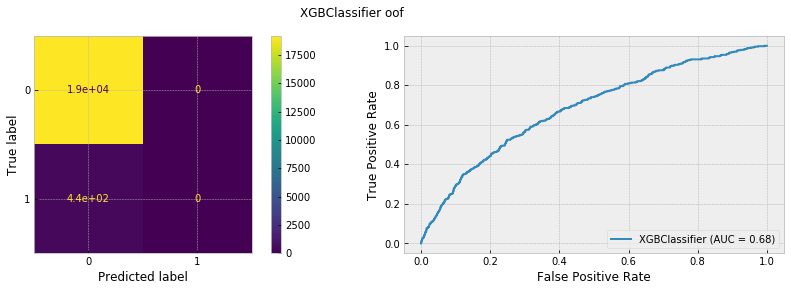

# XGBClassifier RS:77           5x CV: 0.68788 ± 0.00740           OOF: 0.68238


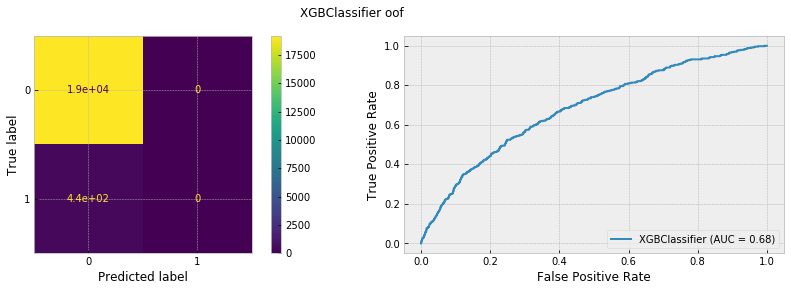

# XGBClassifier RS:77         10x CV: 0.68788 ± 0.00740         OOF: 0.68238 ~['field10', 'field14']


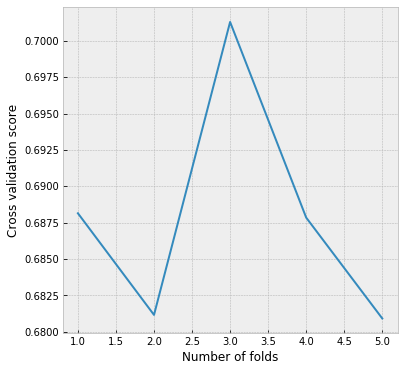

CPU times: user 10.4 s, sys: 1.8 s, total: 12.2 s
Wall time: 12.2 s


In [0]:
# baseline: 0.6909 ± 0.0085.
# XGBClassifier CV: 0.6885 ± 0.0078 OOF: 0.6852 - baseline
# XGBClassifier CV: 0.6890 ± 0.0083 OOF: 0.6871 - ~['field5', 'field20']
# XGBClassifier CV: 0.6884 ± 0.0090 OOF: 0.6878 - ~['field8', 'field10', 'field17']

# XGBClassifier RS:77 5x CV: 0.68655 ± 0.00717 OOF: 0.70138 ~['field10', 'field14']


%%time
X, y = prepare_data(df_train)


try:
  if len(models) > 0:
    for m in models: del m
    models = []
except:
  pass

scores, models, neighbs, polies = fit_estimate(X, y,
        #lambda: skl.ensemble.BaggingClassifier(XGBClassifier(**get_best_params_xgbc()), n_estimators=10, random_state=RS, oob_score=True),
        lambda: XGBClassifier(**get_best_params_xgbc()), 
        n_folds=5, degree=0, n_neighbors=0) #, plot=True)

model = models[np.argmax(scores)]
#neigh = neighbs[np.argmax(scores)]

# estimate OOF
oof = oof_estimate_plot(model)
print(f'# {type(model).__name__} RS:{RS} \
        {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} \
        OOF: {oof:.5f} ~{[x for x in FTS if x not in X.columns]}')

plot_cv_scores(scores)

del X

In [0]:
a = df_train.groupby('userid', as_index=False).count()
a = a[a.field0 > 1]
a = df_train.loc[df_train.userid.isin([*a.userid])]
a.goal1.hist()

In [0]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
17,field7_field16,0.224827
22,field21_0,0.115388
34,field10_0,0.101748
19,field12_field16,0.088139
21,field12_field25,0.080946
...,...,...
35,field10_1,0.000000
32,field9_3,0.000000
51,field19_8,0.000000
50,field19_7,0.000000


In [0]:
import shap
%time shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

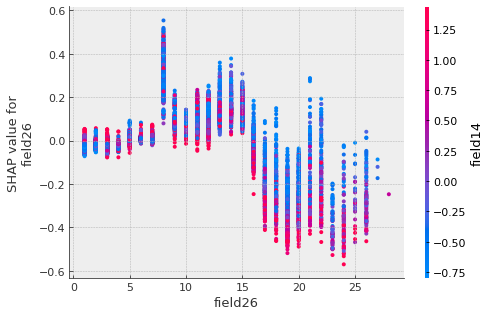

In [0]:
shap.dependence_plot("field26", shap_values, X)

In [0]:
X, y = prepare_data( df_train )

import seaborn as sns
Y = X.head(2000)
Y['goal1'] = y.values.ravel()
sns.pairplot(Y, diag_kind="kde")

## SearchGridCV

In [0]:
X, y = prepare_data( df_train )

params = { 
  'metric': ['rmse', 'rmsle', 'mae', 'logloss', 'error', 'error@t', 'merror', 
                  'mlogloss', 'auc', 'aucpr', 'ndcg', 'map', 'ndcg@n', 'ndcg@n', 
                  'ndcg-', 'map-', 'ndcg@n-', 'ndcg@n-']

  }

gs = GridSearchCV(LGBMClassifier(**get_best_params_lgbm()),
                  params, 
                  cv=KFold( n_splits = 5, shuffle=True, random_state=RS),
                  verbose=10, 
                  n_jobs=-1,
                  scoring='roc_auc')
gs.fit(X, y)
print( gs.best_params_ )
print( gs.best_score_ )

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

{'metric': 'rmse'}
0.6785321104213122


In [0]:
X, y = prepare_data( df_train )

X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=True)

model = XGBClassifier(**get_best_params()).fit(X, y.values.ravel())

plot_permutation_importance(model, X_train, y_train, X_cv, y_cv)

estimate(X, y, model);

In [0]:
X.columns[sorted_idx]

Index(['field5', 'field19', 'field7', 'field2', 'field15', 'field8', 'field20',
       'field0', 'field16', 'field4', 'field9', 'field17', 'field18', 'field1',
       'field14', 'field11', 'field12', 'field6', 'field21', 'field13',
       'field3', 'field10'],
      dtype='object')

## RandomizedSearchCV

In [0]:
%%time

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   
import sklearn.ensemble

X, y = prepare_data(df_train)

params = {'base_score': sp_randFloat(),
 'colsample_bylevel': sp_randFloat(),
 'colsample_bynode': sp_randFloat(),
 'colsample_bytree': sp_randFloat(),
 'gamma': sp_randInt(0, 100),
 'learning_rate': sp_randFloat(),
 'max_delta_step': sp_randInt(0, 100),
 'max_depth': sp_randInt(2, 10),
 'min_child_weight': sp_randFloat(),
 'n_estimators': sp_randInt(10, 500),
 'reg_alpha': sp_randFloat(),
 'reg_lambda': sp_randFloat(),
 'scale_pos_weight': sp_randFloat(),
 'subsample': sp_randFloat(),
 }

params_lgbm = {
  'colsample_bytree': sp_randFloat(),
  'learning_rate': sp_randFloat(),
  'max_depth': sp_randInt(2, 50),
  'min_child_samples': sp_randInt(2, 50),
  'min_child_weight': sp_randFloat(),
  'min_split_gain': sp_randFloat(),
  'n_estimators': sp_randInt(10, 500),
  'num_leaves': sp_randInt(1, 200),
  'reg_alpha': sp_randFloat(),
  'reg_lambda': sp_randFloat(),
  'subsample': sp_randFloat(),
  'subsample_freq': sp_randInt(0, 50),
  }

#clf = LGBMClassifier(**get_best_params_lgbm())
clf = XGBClassifier(**get_best_params_xgbc())
rs = RandomizedSearchCV(clf, 
                        param_distributions=params, 
                        cv=5, 
                        verbose=1, 
                        n_iter=500, 
                        scoring='roc_auc',
                        #n_jobs=-1
                        )
rs.fit(X, y.values.ravel())
print( rs.best_params_ )
print( rs.best_score_ )

with open('Randomized_5f_200iter.txt', 'w') as text_file:
  print(f"best_score_: {rs.best_score_}", file=text_file)
  print(f"best_params_: {rs.best_params_}", file=text_file)
  text_file.close()
files.download('Randomized_5f_200iter.txt')

In [0]:
rs.best_estimator_.get_params()

In [0]:
X_train.shape, X_cv.shape, 

((14116, 10, 30), (3529, 10, 30))

## Neural Networks

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            24320     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dense (Dense)                (None, 10, 2)             130       
Total params: 57,474
Trainable params: 57,474
Non-trainable params: 0
_________________________________________________________________
Train on 14116 samples, validate on 3529 samples
Epoch 1/500
14116/14116 [==============================] - 5s 364us/sample - loss: 0.4756 - sparse_categorical_crossentropy: 0.1316 - val_loss: 0.1167 - val_sparse_categorical_crossentropy: 0.1069
Epoch 2/500
14116/14116 [==============================] - 2s 159us/sample - loss: 0.1078 - sparse_categorical_crossentropy: 0.1041 - va

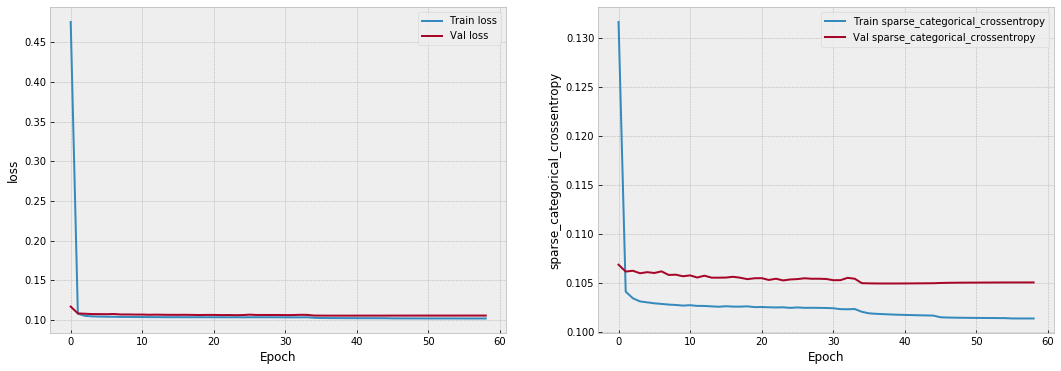

loss: 0.1053 sparse_categorical_crossentropy: 0.1049 


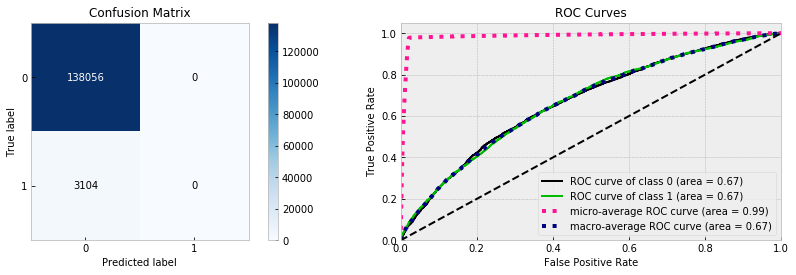

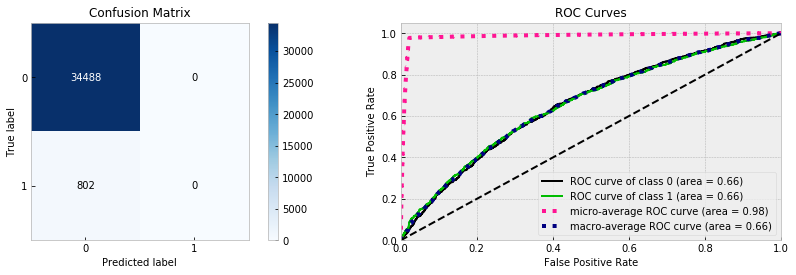

In [0]:
tf.keras.backend.clear_session()

EPOCHS = 500
BS = 64
BLOCK=10

X, y = prepare_data(df_train)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.2)
FEATURES_NUM = X_train.shape[1]

#center, scale = X_train.mean().values, X_train.std().values
#X_train = (X_train.values - center)/scale
#X_cv = (X_cv.values - center)/scale

X_train = X_train.values.reshape(-1, BLOCK, FEATURES_NUM)
y_train_ = y_train.reshape(-1, BLOCK, 1)

X_cv = X_cv.values.reshape(-1, BLOCK, FEATURES_NUM)
y_cv_ = y_cv.reshape(-1, BLOCK, 1)

weight_decay = 0.03
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(BLOCK, FEATURES_NUM)),
    tf.keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(weight_decay)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(2, activation='softmax'),
  ])
optimizer=keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, 
              metrics=[#tf.keras.metrics.AUC(), 
                      'sparse_categorical_crossentropy'
                      ], 
              loss='sparse_categorical_crossentropy'
              )
model.summary()
model.reset_states()

class ResetStatesCallback(keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs):
        self.model.reset_states()

lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.1, patience=10, monitor='val_loss', mode='min')
early_stop = keras.callbacks.EarlyStopping( patience=20, monitor='val_loss', mode='min' )
model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
reset_states = ResetStatesCallback()

callbacks = [ early_stop, 
        model_save, 
        lr_schedule,
        reset_states
        ]

history = model.fit(X_train, y_train_,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=1,
          validation_data=(X_cv, y_cv_),
          callbacks=callbacks)

model = keras.models.load_model('my_checkpoint.h5')

plot_history(history, model.metrics_names)

score = model.evaluate(X_cv, y_cv_, 
                        batch_size=BS, 
                        verbose=0,
                        use_multiprocessing=True)

metrics = ''
for i in range(len(model.metrics_names)):
  metrics += f'{model.metrics_names[i]}: {score[i]:.4f} '

print(metrics)

model.reset_states()

train_pred_proba = model.predict(X_train, use_multiprocessing=True)
train_pred_proba = train_pred_proba.reshape(-1, 2)
train_pred = train_pred_proba.argmax(axis=1)
cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, 2)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_train, train_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_train, train_pred_proba, ax=ax2)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
plt.show()

In [0]:
model = keras.models.load_model('my_checkpoint.h5')


X_test, _ = prepare_data( df_test )
X_test = X_test[:(X_test.shape[0]//10)*10]
X_test = (X_test.values - center)/scale

X_test = X_test.reshape(-1, BLOCK, FEATURES_NUM)
test_pred_proba = model.predict(X_test, use_multiprocessing=True)
test_pred_proba = test_pred_proba.reshape(-1, 2)

zero = np.zeros(df_test.shape[0])
zero[:test_pred_proba.shape[0]] = test_pred_proba[:, 1]

pd.DataFrame(zero, columns=['proba'], index=df_test.index.rename('orderid')).to_csv('sub1.csv')

In [0]:
test_pred

array([0.02045105, 0.02561184, 0.02155982, ..., 0.02158574, 0.01821708,
       0.01149145], dtype=float32)

## Submit the result

In [0]:
model.best_ntree_limit

290

In [0]:
X_test, _ = prepare_data( df_test )
#X_test = add_neighbors_inner(X_test, neigh)

if hasattr(model, 'best_ntree_limit'):
  print(0)
  proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)
else:
  print(1)
  proba = model.predict_proba(X_test)

pd.DataFrame(proba[:, 1], columns=['proba'], index=X_test.index.rename('orderid')).to_csv('sub1.csv')
files.download('sub1.csv')

1


In [0]:
!zip sub1.csv.zip sub1.csv
files.download('sub1.csv.zip')

In [0]:
pd.DataFrame(proba[:, 1], columns=['proba'], index=X_test.index.rename('orderid'))

In [0]:
!pip3 install -q eli5
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
!pip3 install -q catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 63.6MB 124kB/s 


In [0]:
!pip install -q shap

In [0]:
kepler = pd.read_csv("../input/cumulative.csv")
kepler = (kepler
     .drop(['rowid', 'kepid'], axis='columns')
     .rename(columns={'koi_disposition': 'disposition', 'koi_pdisposition': 'predisposition'})
     .pipe(lambda df: df.assign(disposition=(df.disposition == 'CONFIRMED').astype(int), predisposition=(df.predisposition == 'CANDIDATE').astype(int)))
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')])  # drop str columns
     .pipe(lambda df: df.loc[:, (df.isnull().sum(axis='rows') < 500).where(lambda v: v).dropna().index.values])  # drop columns with greater than 500 null values
     .dropna()
)

kepler_X = kepler.iloc[:, 1:]
kepler_y = kepler.iloc[:, 0]

os.path.join(
    
os.path.join(path, "User/Desktop", "file.txt")